<a href="https://colab.research.google.com/github/zeliky/deep-learning-fp/blob/main/final_project_CustomCnnLSTM12_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
from scipy.io import loadmat
import numpy as np
from PIL import Image,ImageShow
import matplotlib.pyplot as plt
import re
import os
import math
import random
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import Sequence, to_categorical
from concurrent.futures import ThreadPoolExecutor

In [4]:
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
BASE_PATH  = '/gdrive/MyDrive/deep-learning/final-project/data-sets/'
ORIGINAL_IMAGES = BASE_PATH + "0_Images/"
ROTATED_IMAGES =  BASE_PATH + "1_ImagesRotated/"
MEDIAN_BW_IMAGES =  BASE_PATH + "2_ImagesMedianBW/"
LINES_REMOVED_BW_IMAGES =  BASE_PATH + "3_ImagesLinesRemovedBW/"
LINES_REMOVED_IMAGES =  BASE_PATH + "4_ImagesLinesRemoved/"
DARK_LINES =  BASE_PATH + "5_DataDarkLines/"
SAMPLE_FILE_PATTERN = "lines{}_Page_{}.jpg"
METADATA_PATTERN = "lines{}_Page_{}.mat"
MODEL_CHECKPOINT_PATH = BASE_PATH + "model_checkpoints/"

NUMPY_STORAGE=  BASE_PATH +"numpy_storage/{}_train_validation.npz"
ALLOWED_TYPES = [ORIGINAL_IMAGES,ROTATED_IMAGES, MEDIAN_BW_IMAGES, LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
TRAIN_TYPES =  [ LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
VALIDATE_TYPES =  [ ROTATED_IMAGES, MEDIAN_BW_IMAGES]
LINE_SHAPE = (225, 4965)
INPUT_SQUARE = (227, 227)

MODE_TRAIN = 'train'
MODE_VALIDATION = 'validation'
MODE_TEST = 'test'


In [6]:
class MetaData:
  @staticmethod
  def from_mat_data(data):
    metadata = MetaData()
    SCALE_FACTOR = data['SCALE_FACTOR'].flatten()[0]
    peaks_indices = data['peaks_indices'].flatten()
    metadata.min_y  = SCALE_FACTOR * min(peaks_indices)
    metadata.max_y  = SCALE_FACTOR *  max(peaks_indices)
    metadata.peaks_indices = [SCALE_FACTOR*a - metadata.min_y for a in  peaks_indices]
    metadata.index_of_max_in_peak_indices = data['index_of_max_in_peak_indices'].flatten()[0]
    metadata.delta = data['delta'].flatten()[0]
    metadata.top_test_area = data['top_test_area'].flatten()[0] - metadata.min_y
    metadata.bottom_test_area = data['bottom_test_area'].flatten()[0] - metadata.min_y
    metadata.total_lines = len(metadata.peaks_indices)
    return metadata

  def __repr__(self):
    return str(self.__dict__)


In [7]:
class ModelOptions:
    def __init__(self, **kwargs):
        self.num_classes = kwargs.get('num_classes', 10)
        self.batch_size = kwargs.get('batch_size', 100)
        self.image_height = kwargs.get('image_height', 50)
        self.image_width = kwargs.get('image_width', 50)
        self.num_channels = kwargs.get('num_channels', 1)
        self.max_sequence_length = kwargs.get('max_sequence_length', 32)
        self.random_shuffle_amount = kwargs.get('random_shuffle_amount', 0)
        self.lstm_units = kwargs.get('lstm_units', 5)
        self.max_embedding_samples = kwargs.get('max_embedding_samples', 5)

    def __repr__(self):
        return str(self.__dict__)

In [8]:
class DataSet:
    def __init__(self):
        self.user_files = {}
        self.metadata = {}
        self._build_index()
        self.reset()

    def reset(self):
        self.images = {}

    def load_image(self, path, user_id):
        bin, id = self.user_files[user_id]
        image_type = self._image_type(path)

        file_name = SAMPLE_FILE_PATTERN.format(bin, id)
        image_path = "{}{}".format(path, file_name)
        image_metadata = self._get_cached_metadata(user_id)
        if image_metadata is None:
            image_metadata = self.image_metadata(user_id)
            self._cache_metadata(user_id, image_metadata)

        user_file = self._get_cached_image(image_type, user_id)
        if user_file is None:
            print('loading image from {}'.format(image_path))
            with open(image_path, 'r') as f:
                im = Image.open(image_path)
                user_file = UserFile(im, image_metadata)
                self._cache_image(image_type, user_id, user_file)
        return user_file

    def image_metadata(self, user_id):
        bin, id = self.user_files[user_id]
        file_name = METADATA_PATTERN.format(bin, id)
        metadata_path = "{}{}".format(DARK_LINES, file_name)
        # print(metadata_path)
        data = loadmat(metadata_path)
        return MetaData.from_mat_data(data)

    def _image_type(self, path):
        reg = re.search(r'\d+', path)
        return int(reg.group())


    def _build_index(self):
        directory_files = os.listdir(ORIGINAL_IMAGES)
        for idx, fname in enumerate(directory_files):
            pattern = re.search(r'lines(\d+)_Page_(\d+)', fname.replace(BASE_PATH, ''))
            self.user_files[idx] = (pattern.group(1), pattern.group(2))

    def _get_cached_image(self, image_type, user_id):
        if image_type in self.images and user_id in self.images[image_type]:
            return self.images[image_type][user_id]
        return None

    def _cache_image(self, image_type, user_id, image):
        if image_type not in self.images:
            self.images[image_type] = {}
        if user_id not in self.images[image_type]:
            self.images[image_type][user_id] = image

    def _get_cached_metadata(self, user_id):
        if user_id in self.metadata:
            return self.metadata[user_id]
        return None

    def _cache_metadata(self, user_id, metadata: MetaData):
        self.metadata[user_id] = metadata


# -------------------------------------------------------------------------------
#should be kept global so it will be shared by multi processes
full_data_set = DataSet()

In [9]:
class UserFile:
    def __init__(self, im, metadata):
        # image_arr = np.asarray(im.getchannel(0).getdata())
        self.im = im.copy()
        if im.mode != 'L':
            im = im.convert(mode='L')
        image_arr = np.asarray(im.getchannel(0))
        # image_arr = image_arr.reshape(im.height, im.width)
        # print(image_arr.shape)
        self.data = image_arr[metadata.min_y: metadata.max_y, :]
        self.metadata = metadata

    def get_testing_line(self):
        y_range = (self.metadata.top_test_area, self.metadata.bottom_test_area)
        return self.data[y_range[0]:y_range[1], :]

    def get_test_line_idx(self):
        for i in range(1, self.metadata.total_lines):
            if self.is_test_line(i):
                return i

    def get_all_lines(self, threshold=2000):
        for i in range(1, self.metadata.total_lines):
            yield self.get_line(i)

    def get_line(self, line_idx):
        y_range = (self.metadata.peaks_indices[line_idx - 1:line_idx + 1])
        return self.data[y_range[0]:y_range[1] + 30, :]

    def is_test_line(self, line_idx):
        bounderies = self.metadata.peaks_indices[line_idx - 1:line_idx + 1]
        return abs(int(bounderies[0]) - self.metadata.top_test_area) < 50 and abs(
            int(bounderies[1]) - self.metadata.bottom_test_area) < 50

    def show(self):
        image = Image.fromarray(self.data.astype(np.uint8))
        image.show()


In [45]:
class UserDataset:
    def __init__(self, user_id):
        self.user_id = user_id
        self.train_lines = []
        self.validation_lines = []
        self.all_lines = []
        self.test_line = None
        self.split_points = {}
        self.min_width = 20
        self.min_colored_pixels = 500 * 255

    def warmup(self):
        e = ThreadPoolExecutor(max_workers=len(ALLOWED_TYPES))
        futures = [e.submit(full_data_set.load_image, t, self.user_id) for t in ALLOWED_TYPES]
        results = [f.result() for f in futures]
        self.split_dataset()

    def split_dataset(self, train_split=0.8):
        bw_image = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        self.train_lines, self.validation_lines = select_train_validation_lines(bw_image)
        self.test_line = bw_image.get_test_line_idx()
        self.all_lines = sorted(self.train_lines + self.validation_lines)

    def get_letters(self, img_path, line_idx, target_size):
        split_points = self._get_characters_split_points(line_idx)
        user_file = full_data_set.load_image(img_path, self.user_id)
        line = normalized_line(user_file.get_line(line_idx))
        for (x, y, w, h) in split_points:
            img = line[:, x:x + w]
            # print(f"get_letter shape {img.shape}")
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            yield np_img
        return

    def get_line_as_sequence(self, img_path, line_idx, max_sequence_length, target_size):
        sequence = []
        user_file = full_data_set.load_image(img_path, self.user_id)
        line = normalized_line(user_file.get_line(line_idx))
        split_points = self._get_characters_split_points(line_idx)
        for (x, y, w, h) in split_points:
            img = line[:, x:x + w]
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            sequence.append(np_img)
        return pad_sequence(max_sequence_length, sequence,target_size[0], target_size[1], 1)

    def random_line_generator(self, mode, max_sequence_length, target_size, sample_from_lines_amount=None,
                              sequence_length=None, original_only=False):
        while True:
            types = ALLOWED_TYPES if not original_only else [ORIGINAL_IMAGES]
            img_path = random.choice(types)
            user_file = full_data_set.load_image(img_path, self.user_id)

            lines = self._get_lines_ids_set(mode)
            if sample_from_lines_amount is None:
                sample_from_lines_amount = random.randint(1, len(lines) - 1)
            selected_lines = random.sample(lines, sample_from_lines_amount)
            if sequence_length is None:
                sequence_length = random.randint(int(0.3 * max_sequence_length), max_sequence_length)
            sequence = []
            for _ in range(sequence_length):
                line_idx = random.choice(selected_lines)
                line = normalized_line(user_file.get_line(line_idx))
                split_points = self._get_characters_split_points(line_idx)
                (x, y, w, h) = random.choice(split_points)
                img = line[:, x:x + w]
                thumbnail = create_thumbnail(img, target_size)
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                sequence.append(np_img)
            yield pad_sequence(max_sequence_length, sequence,target_size[0], target_size[1], 1)


    def random_letters_generator(self, mode, target_size, random_shuffle_amount=1, original_only=False):
        while True:
            types = ALLOWED_TYPES if not original_only else [ORIGINAL_IMAGES]
            img_path = random.choice(types)
            user_file = full_data_set.load_image(img_path, self.user_id)

            lines = self._get_lines_ids_set(mode)
            line_idx = random.choice(lines)
            line = normalized_line(user_file.get_line(line_idx))
            split_points = self._get_characters_split_points(line_idx)
            (x, y, w, h) = random.choice(split_points)

            img = line[:, x:x + w]
            thumbnails = [create_thumbnail(img, target_size) for _ in range(random_shuffle_amount)]
            for i, thumbnail in enumerate(thumbnails):
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                # print(f"{img_path}: u:{self.user_id} l:{line_idx} x:{x}-{x+w} rand:{i}")
                yield np_img

    def _get_lines_ids_set(self, mode):
        if mode == MODE_TRAIN:
            return self.train_lines
        elif mode == MODE_VALIDATION:
            return self.validation_lines
        return [self.test_line]

    def _get_characters_split_points(self, idx):
        if idx in self.split_points:
            return self.split_points[idx]
        img = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        line = normalized_line(img.get_line(idx))
        binary = np.where(line > 30, 1, 0).astype('uint8')
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
        dilation = cv2.dilate(binary, rect_kernel, iterations=1)
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        split_points = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > self.min_width:
                sub_img = line[:, x:x + w]
                # print(f"_get_characters_split_points line \t {idx}\t{x}\t{x+w}\t{sub_img.sum()}")
                if sub_img.sum() > self.min_colored_pixels:
                    split_points.append((x, y, w, h))

        self.split_points[idx] = sorted(split_points, key=lambda tup: tup[0])
        # print( self.split_points[idx])
        return self.split_points[idx]




In [44]:
def image_dots(img_data,threshold=50):
  height, width = img_data.shape
  for i in range(height):
    line =''
    for j in range(width):
      if img_data[i,j]<threshold:
        line += ' '
      else:
        line += '.'
    print(line)

def show_line(line_data):
    image = Image.fromarray(line_data.astype(np.uint8))
    image.show()


def is_empty_line(line_data, threshold=5000):
    values = line_data.flatten()
    sum = values[values < 50].sum()
    #print("is_empty_line {}".format(sum))
    return sum < threshold


def normalized_line(line_data):
    desired_shape = LINE_SHAPE
    # normalized_data =  (255 - line_data) / 255.0
    normalized_data = (255 - line_data)
    pad_rows = max(0, desired_shape[0] - normalized_data.shape[0])
    pad_cols = max(0, desired_shape[1] - normalized_data.shape[1])

    padded_array = np.pad(normalized_data, ((0, pad_rows), (0, pad_cols)), mode='constant')
    return padded_array


def select_train_validation_lines(user_image, train_split=0.8):
    rows = []
    for i, line in enumerate(user_image.get_all_lines()):
        idx = i + 1
        if not user_image.is_test_line(idx) and not is_empty_line(line):
            rows.append(idx)

    random.shuffle(rows)
    split_idx = int(len(rows) * train_split)
    return (rows[0:split_idx], rows[split_idx:])


def split_and_shuffle_array(arr, split_points):
    chunks = split_array(arr, split_points)
    np.random.shuffle(chunks)
    shuffled_array = np.concatenate(chunks, axis=1)
    return shuffled_array


def split_array(arr, split_points):
    chunks = []
    start_idx = 0
    for end_idx in split_points:
        chunk = arr[:, start_idx:end_idx]
        chunks.append(chunk)
        start_idx = end_idx
    last_chunk = arr[:, start_idx:]
    chunks.append(last_chunk)
    return chunks


def create_thumbnail(image_array, target_size):
    height, width = image_array.shape
    target_height, target_width = target_size
    org_image = Image.fromarray(image_array)

    random_scale_w = random.uniform(0.8, 1.2)
    random_scale_h = random.uniform(0.8, 1.2)
    random_rotate =  random.randint(-15, 15)
    org_image_rs = org_image.resize((int(width*random_scale_w) , int(height*random_scale_h)),  Image.NEAREST)
    org_image_ro = org_image_rs.rotate(random_rotate, Image.NEAREST,expand=True)

    canvas = Image.new("L", (height, height), 0)
    if width < height:
        left = (height - width) // 2
        top = 0
        canvas.paste(org_image_ro, (left, top))
    else:
        scale_factor = height / width
        s_width = round(scale_factor * width)
        s_height = round(scale_factor * height)
        resized_image = org_image_ro.resize((s_width, s_height), Image.NEAREST)
        left = (height - s_width) // 2
        top = 0
        canvas.paste(resized_image, (left, top))
        del resized_image

    del org_image_rs
    del org_image_ro
    del org_image


    thumbnail = canvas.resize((target_width, target_height), Image.NEAREST)
    return thumbnail

def show_sequence(the_images):
    l = len(the_images)
    dim = math.ceil(math.sqrt(l))
    plt.clf()
    fig, axs = plt.subplots(dim, dim, figsize=(10, 10))
    k = 0
    for i in range(0, dim):
        for j in range(0, dim):
            img = the_images[k]
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            k += 1
            if k == l:
                plt.show()
                return


def show_triplet(triplets):
    plt.clf()
    fig, axs = plt.subplots(1, 3, figsize=(5, 5))

    for k in range(0, 3):
        img = triplets[k]
        axs[k].imshow(img, cmap='gray')
        axs[k].axis('off')

    plt.show()

def pad_sequence(max_sequence_length, sequence, image_height, image_width, num_channels):
    sequence = np.asarray(sequence)
    padding_size = max_sequence_length - len(sequence)
    if padding_size > 0:
        padding_shape = (padding_size, image_height, image_width, num_channels)
        padding_images = np.zeros(padding_shape)
        padded_sequence = np.concatenate([sequence, padding_images], axis=0)
    else:
        padded_sequence = np.asarray(sequence)
    return padded_sequence

def pad_sequences(max_length, sequences, image_height, image_width, num_channels):
    # Pad sequences to have the same length (pad with zero images)
    padded_sequences = []
    for sequence in sequences:
        seq_len = len(sequence)
        if seq_len == 0:
            continue
        if seq_len > max_length:
            sequence = sequence[:max_length]
            seq_len = len(sequence)

        num_padding = max_length - seq_len
        if num_padding > 0:
            sequence = np.concatenate(
                [sequence, np.zeros((num_padding, image_height, image_width, num_channels))])
        padded_sequences.append(sequence)
    return np.array(padded_sequences)

In [40]:
class FinalStopIteration(StopIteration):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)


In [59]:
class SequenceGenerator(Sequence):

    def __init__(self, mode, user_ids, model_options: ModelOptions):
        self.options = model_options
        self.user_ids = [i for i in user_ids]
        self.id_to_class = {user_id: i for i, user_id in enumerate(user_ids)}
        self.input_shape = (model_options.image_height, model_options.image_width)
        self.usage_stats = {}
        self.num_classes = model_options.num_classes
        self.users_ds = {}
        self.generators = {}
        self.mode = mode

    def on_epoch_end(self):
        self.generators = {}

    def incr_usage(self, user_id):
        if user_id not in self.usage_stats:
            self.usage_stats[user_id] = 0
        self.usage_stats[user_id] += 1

    def max_usages_per_user(self):
        lines = 50
        return lines * self.options.random_shuffle_amount

    def get_user_ds(self, user_id):
        if user_id not in self.users_ds:
            uds = UserDataset(user_id)
            uds.warmup()
            self.users_ds[user_id] = uds
        self.incr_usage(user_id)
        return self.users_ds[user_id]

    def get_sequence_generator(self, user_id):
        if user_id not in self.generators:
            #print(f"new generator for {user_id}")
            uds = self.get_user_ds(user_id)
            self.generators[user_id] = uds.random_line_generator(mode=self.mode,
                                                                 max_sequence_length=self.options.max_sequence_length,
                                                                 target_size=self.input_shape)
        return self.generators[user_id]

    def __len__(self):
        lines = 20
        users = len(self.user_ids)
        random_shuffle_amount = self.options.random_shuffle_amount
        types = len(ALLOWED_TYPES)

        total_batches = (types * lines * users * random_shuffle_amount) // self.options.batch_size
        return total_batches

    def __getitem__(self, index):
        batch, labels = [], []
        for s in range(self.options.batch_size):
            user_id = random.choice(self.user_ids)
            sequence = next(self.get_sequence_generator(user_id))
            batch.append(sequence)
            labels.append(to_categorical(self.id_to_class[user_id], num_classes=self.options.num_classes))

        return np.asarray(batch), np.asarray(labels)


Display generators

In [14]:

user_ids = [1]
model_options = ModelOptions(
    num_classes=len(user_ids) ,
    batch_size=100,
    image_height=150,
    image_width=150,
    num_channels=1,
    max_sequence_length=50,
    random_shuffle_amount=1
)


In [15]:
model_options

{'num_classes': 1, 'batch_size': 100, 'image_height': 150, 'image_width': 150, 'num_channels': 1, 'max_sequence_length': 50, 'random_shuffle_amount': 1, 'lstm_units': 5, 'max_embedding_samples': 5}

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines1_Page_01.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/1_ImagesRotated/lines1_Page_01.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/4_ImagesLinesRemoved/lines1_Page_01.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/2_ImagesMedianBW/lines1_Page_01.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines1_Page_01.jpg
[7, 3, 14, 10, 8, 5, 13, 11, 16, 18, 19, 4]
[2, 15, 9, 12]
17


<Figure size 640x480 with 0 Axes>

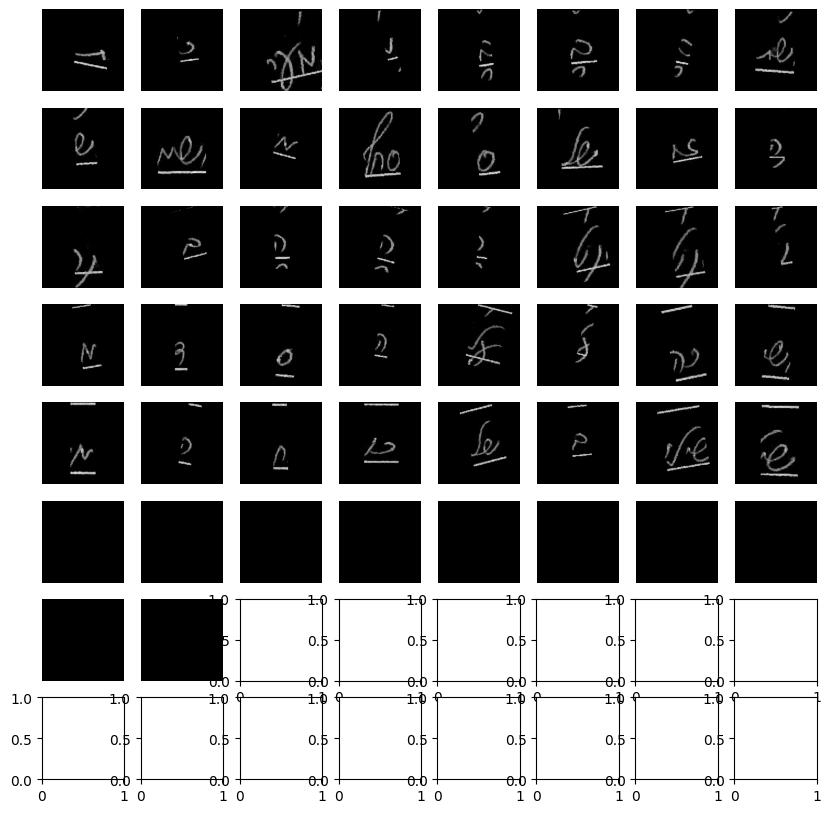

In [47]:
def show_line_as_sequence():
  full_data_set = DataSet()


  uds = UserDataset(1)
  uds.warmup()
  train_lines = uds.train_lines
  print(uds.train_lines)
  print(uds.validation_lines)
  print(uds.test_line)
  sequence = uds.get_line_as_sequence(ORIGINAL_IMAGES,17,model_options.max_sequence_length, (model_options.image_height, model_options.image_width))
  show_sequence(sequence * 255)
  #print(sequence.shape)

full_data_set = DataSet()
show_line_as_sequence()

new generator for 20
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines1_Page_17.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines1_Page_17.jpgloading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/2_ImagesMedianBW/lines1_Page_17.jpg

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/1_ImagesRotated/lines1_Page_17.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/4_ImagesLinesRemoved/lines1_Page_17.jpg
new generator for 16
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/4_ImagesLinesRemoved/lines1_Page_13.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/1_ImagesRotated/lines1_Page_13.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines1_Page_13.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemo

<Figure size 640x480 with 0 Axes>

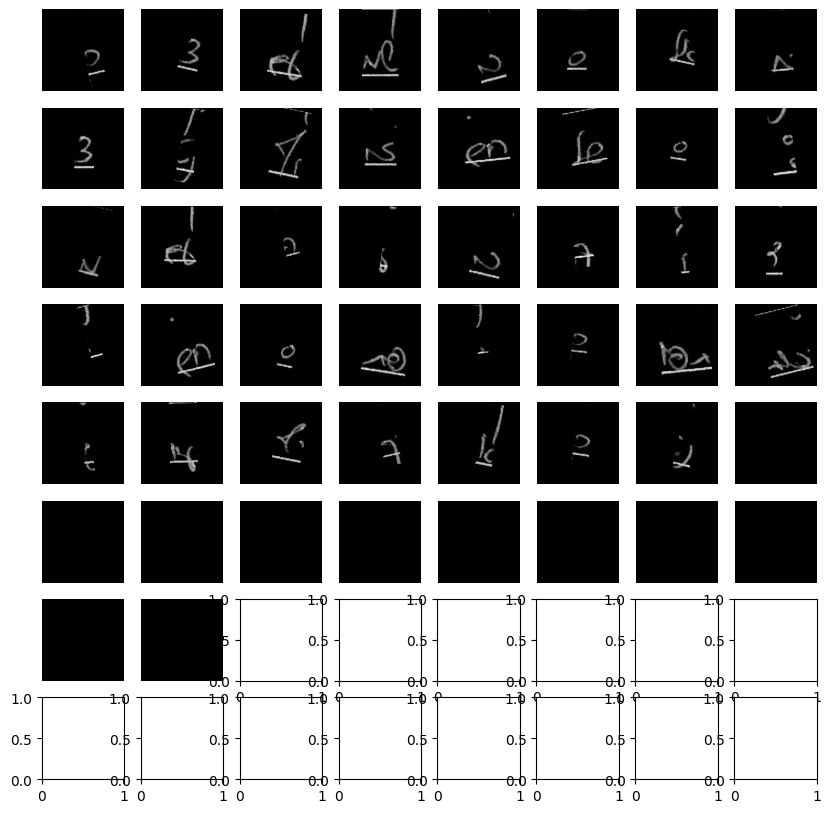

line sequence from user [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<Figure size 640x480 with 0 Axes>

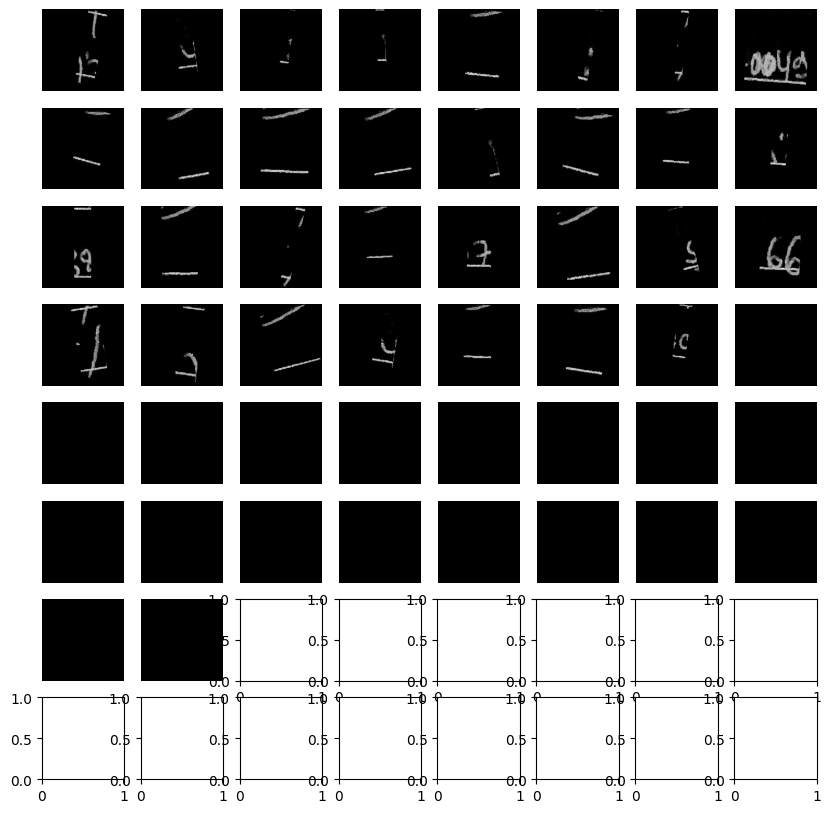

line sequence from user [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 640x480 with 0 Axes>

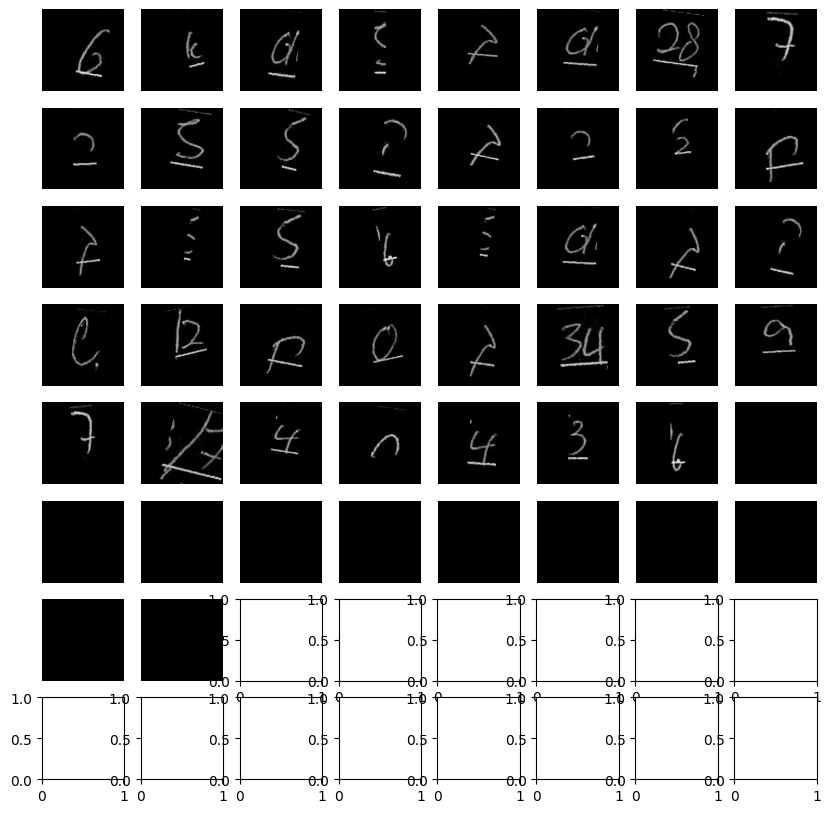

line sequence from user [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<Figure size 640x480 with 0 Axes>

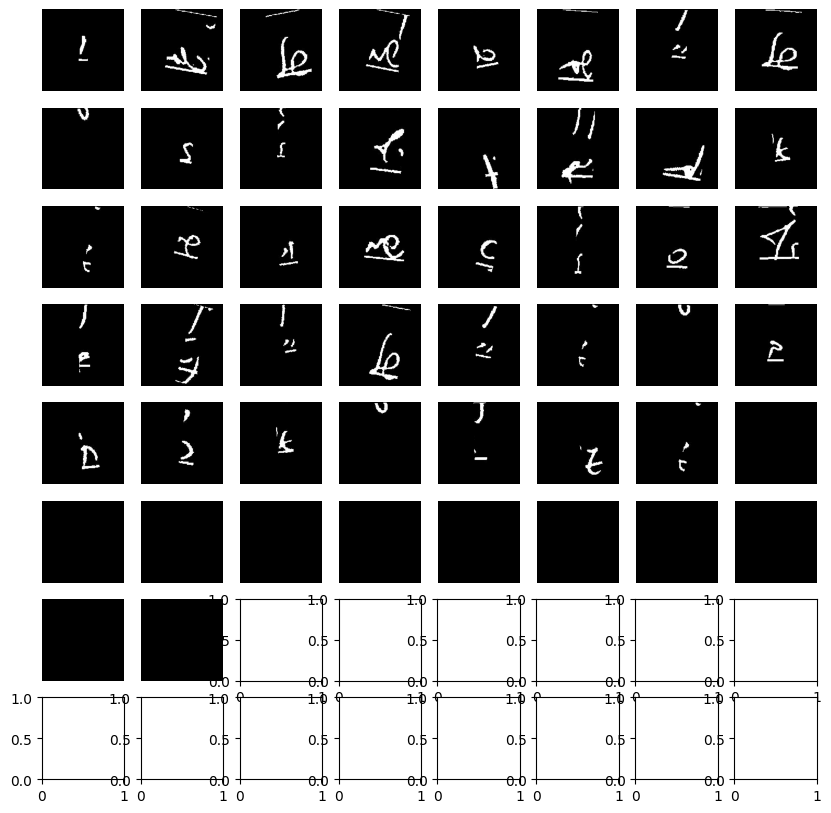

line sequence from user [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 640x480 with 0 Axes>

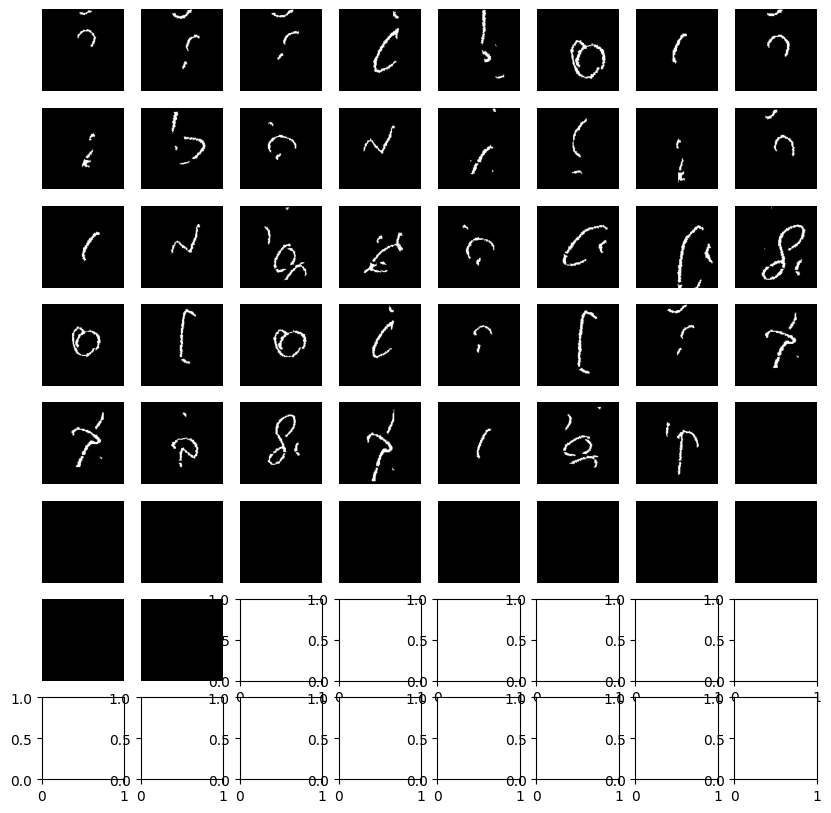

line sequence from user [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 640x480 with 0 Axes>

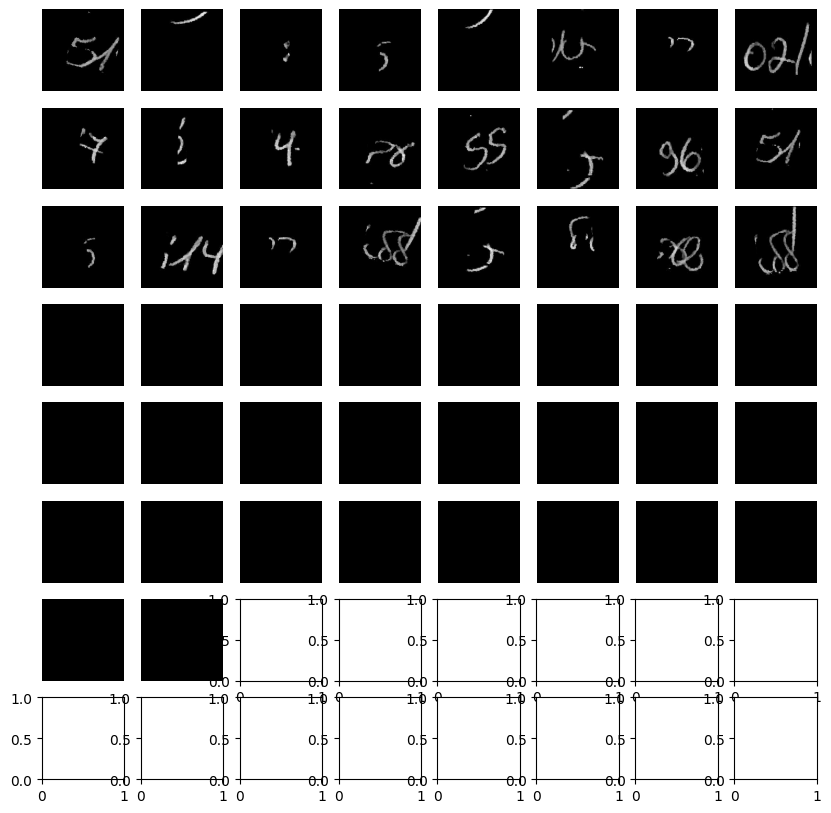

KeyboardInterrupt: ignored

In [58]:
def display_sequences():
    train_gen = SequenceGenerator(MODE_TRAIN, user_ids, model_options)
    valid_gen = SequenceGenerator(MODE_VALIDATION, user_ids, model_options)

    valid_gen.on_epoch_end()
    for i, (batch_x, labels) in enumerate(valid_gen):
        print(batch_x.shape)
        for id, sequence in enumerate(batch_x):
            print(f"line sequence from user {labels[id]}")
            #print(sequence.shape)
            show_sequence(sequence * 255)
            if id == 5:
                break
        break
    valid_gen.on_epoch_end()


full_data_set = DataSet()
display_sequences()

In [79]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input, AdditiveAttention, Flatten
import tensorflow as tf


class CnnLstmAttentionModel:
    def __init__(self, options: ModelOptions, embedding_model, layer_name):
        self.model_options = options
        self.embedding_model = self._convert_to_embedding_model(embedding_model, layer_name)



    def get_model(self, options):
        input_layer = Input(shape=(self.model_options.max_sequence_length, self.model_options.image_height,
                                   self.model_options.image_width, 1))

        # 2) Use the CustomCNN as the embedding
        self.embedding_model.trainable = False

        # Apply CustomCNN to each image in the sequence
        sequence_embedding = TimeDistributed(self.embedding_model)(input_layer)

        # Flatten the output of the CustomCNN model
        flattened_sequence = TimeDistributed(tf.keras.layers.Flatten())(sequence_embedding)

        # LSTM Layer
        lstm_output = LSTM(options['lstm_units'])(flattened_sequence)

        # Additive Attention Layer
        attention_output = AdditiveAttention()([lstm_output, lstm_output])

        # Flattening the output for the Dense layer
        attention_output_flat = Flatten()(attention_output)

        dense_output = Dense(options['dense_units'], activation='relu')(attention_output_flat)

        # 5) Classification Layer
        output = Dense(options['num_classes'], activation='softmax')(dense_output)

        # Build the model
        model = Model(inputs=input_layer, outputs=output)

        return model

    def _convert_to_embedding_model(self, base_model, layer_name):
        return Model(base_model.inputs, base_model.get_layer(layer_name).output)

In [86]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

filepath = MODEL_CHECKPOINT_PATH + "cnnlstm-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

num_epochs = 10
user_ids = [i for i in range(12, 22)]

model_options = ModelOptions(
    num_classes=len(user_ids),
    batch_size=50,
    image_height=150,
    image_width=150,
    num_channels=1,
    max_sequence_length=50,
    random_shuffle_amount=32
)

layers_options = {
    'lstm_units': 128,
    'dense_units': 64,
    'num_classes': model_options.num_classes
}



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# If a GPU is available, the TensorFlow should default to it
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

input_shape = (model_options.image_height, model_options.image_width, 1)
num_classes = len(user_ids)
train_gen = SequenceGenerator(MODE_TRAIN, user_ids, model_options)
valid_gen = SequenceGenerator(MODE_VALIDATION, user_ids, model_options)

embedding_path = MODEL_CHECKPOINT_PATH + 'model-15-0.46.hdf5'
embedding_model = load_model(embedding_path)






Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [87]:
sm = CnnLstmAttentionModel(model_options,embedding_model, 'dense_6')
model = sm.get_model(layers_options)

opt =  Adam(learning_rate=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
                    validation_data=valid_gen, verbose=1, callbacks=callbacks_list)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 50, 150, 15  0           []                               
                                0, 1)]                                                            
                                                                                                  
 time_distributed_28 (TimeDistr  (None, 50, 1024)    10542784    ['input_15[0][0]']               
 ibuted)                                                                                          
                                                                                                  
 time_distributed_29 (TimeDistr  (None, 50, 1024)    0           ['time_distributed_28[0][0]']    
 ibuted)                                                                                   

KeyboardInterrupt: ignored

In [60]:
from keras.models import load_model
filepath = MODEL_CHECKPOINT_PATH + 'cnnlstm-15-0.41.hdf5'
# load the model
loaded_model = load_model(filepath)
loaded_model.summary()
history = loaded_model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
                    validation_data=valid_gen, verbose=1, callbacks=callbacks_list)

OSError: ignored

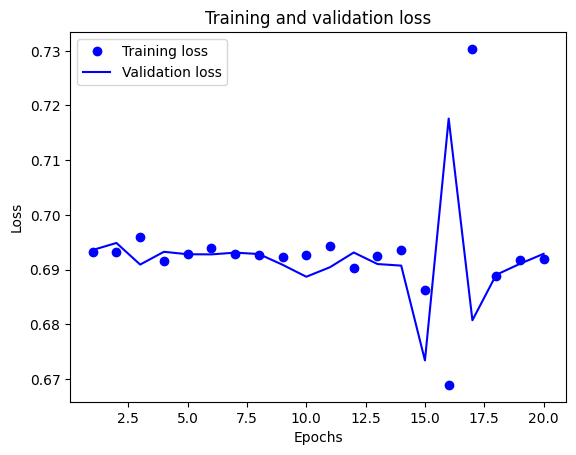

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc  = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
plt.clf()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

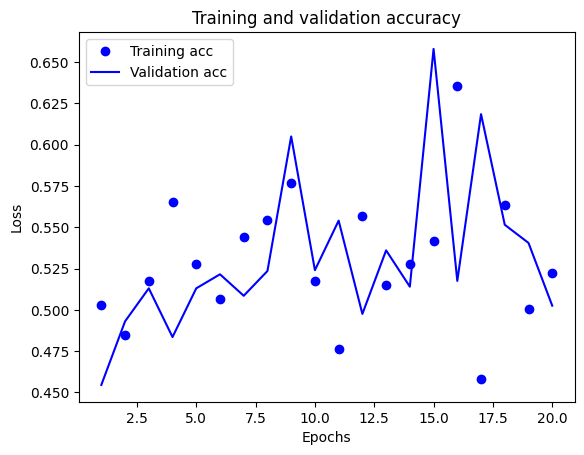

In [ ]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()